In [ ]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 77.7 MB/s eta 0:00:00


In [ ]:
from geopy.geocoders import Nominatim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from pyproj import Transformer
import re

In [ ]:
df = pd.read_excel('/content/ParsData.xlsx')

In [ ]:
cols_check = ['Чистая прибыль', 'Налог на прибыль']
df_clean = df[~df[cols_check].apply(lambda x: x.str.contains('undefined', case=False)).any(axis=1)]
df_clean = df_clean.drop_duplicates(subset=['ИНН', 'Год'], keep='last')

In [ ]:
def calculate_growth(row, base_year, target_year, df):
    """
    Вычисляет процент роста между base_year и target_year для данной компании

    Args:
        row - строка DataFrame с ИНН компании
        base_year - базовый год для сравнения
        target_year - целевой год
        df - исходный DataFrame с данными

    Return:
        Процент роста (int) или np.nan если расчет невозможен
    """
    company_data = df[df['ИНН'] == row['ИНН']]
    profit_base = company_data[company_data['Год'] == base_year]['Чистая прибыль']
    profit_target = company_data[company_data['Год'] == target_year]['Чистая прибыль']

    if profit_base.empty or profit_target.empty:
        return np.nan

    base = profit_base.iloc[0]
    target = profit_target.iloc[0]

    if base == 0:
        if target == 0:
            return 0
        elif target > 0:
            return np.inf
        else:
            return -np.inf

    growth = (target - base) / abs(base) * 100

    return int(round(growth))

In [ ]:
result_df = pd.DataFrame({'ИНН': df_clean['ИНН'].unique()})

for year in range(2019, 2025):
    year_data = df_clean[df_clean['Год'] == year].set_index('ИНН')['Чистая прибыль']
    result_df[f'Прибыль_{year}'] = result_df['ИНН'].map(year_data)

for n_years in range(1, 6):
    base_year = 2024 - n_years
    if base_year >= 2019:
        result_df[f'Рост_{n_years}г'] = result_df.apply(
            lambda x: calculate_growth(x, base_year, 2024, df_clean), axis=1
        )

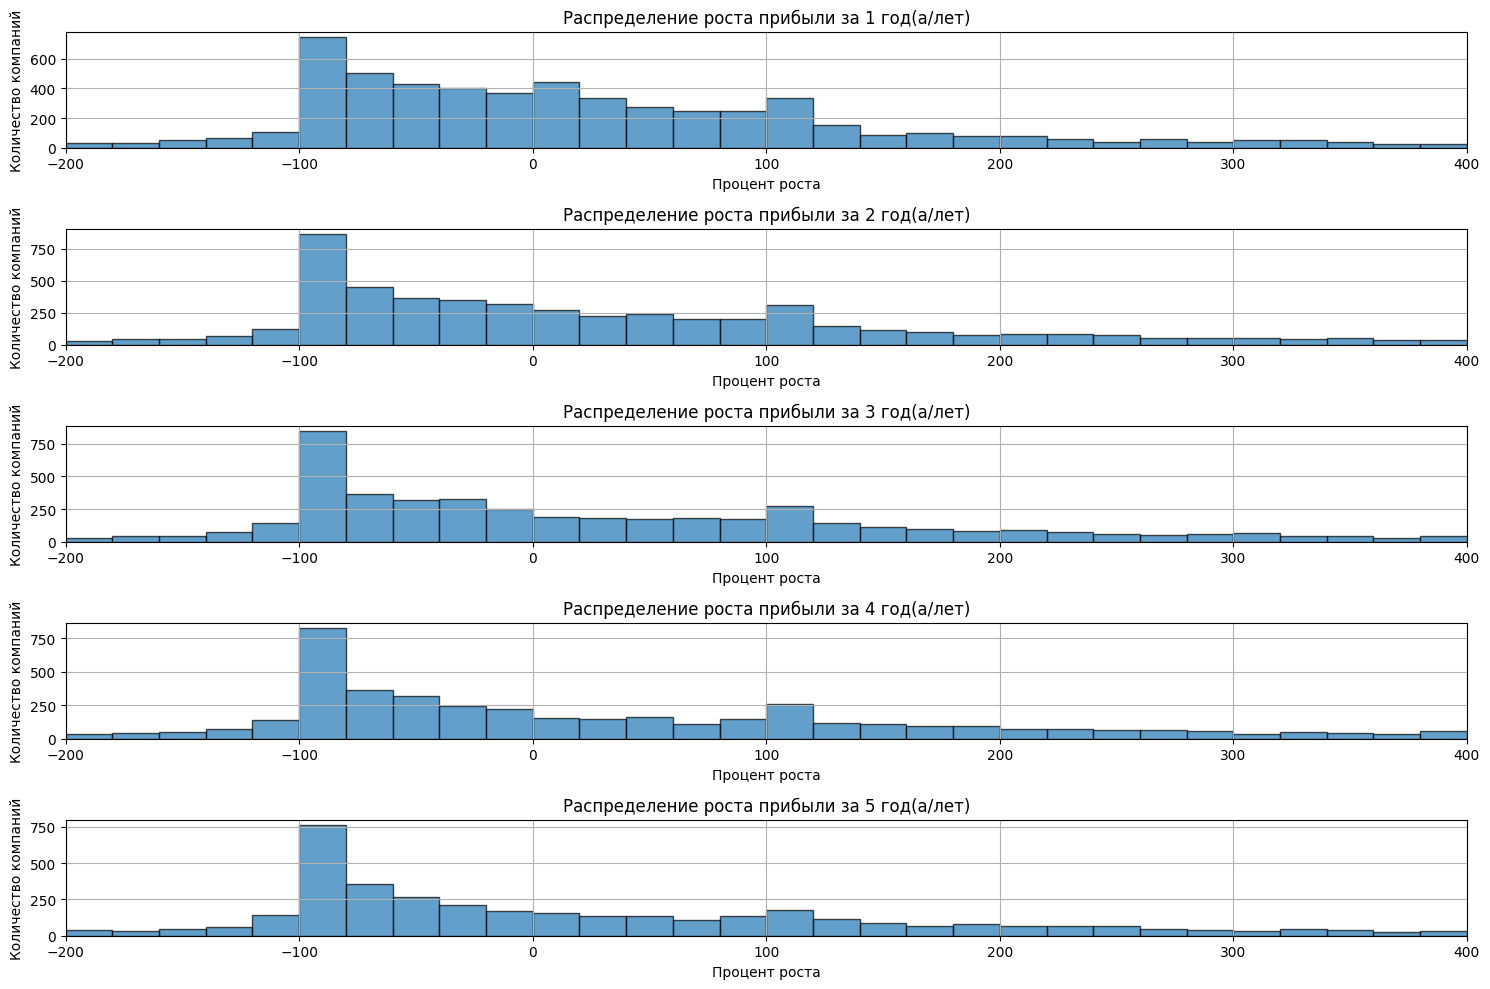

In [ ]:
def filter_inf(df, column):
    return df[~np.isinf(df[column]) & ~np.isnan(df[column])]

N_YEARS = [1, 2, 3, 4, 5]  # Анализ роста за 1, 2 и 3 года
BIN_SIZE = 20  # Ширина столбцов гистограммы (в процентах)
MAX_GROWTH = 400  # Максимальный отображаемый рост
MIN_GROWTH = -200 # Минимальный отображаемый рост

plt.figure(figsize=(15, 10))

for i, n in enumerate(N_YEARS, 1):
    plt.subplot(len(N_YEARS), 1, i)

    col_name = f'Рост_{n}г'
    filtered_df = filter_inf(result_df, col_name)
    growth_rates = filtered_df[col_name].round().astype(int)

    bins = np.arange(MIN_GROWTH, MAX_GROWTH + BIN_SIZE, BIN_SIZE)
    plt.hist(growth_rates, bins=bins, edgecolor='black', alpha=0.7)

    plt.title(f'Распределение роста прибыли за {n} год(а/лет)')
    plt.xlabel('Процент роста')
    plt.ylabel('Количество компаний')
    plt.grid(True)
    plt.xlim(MIN_GROWTH, MAX_GROWTH)

plt.tight_layout()
plt.show()

In [ ]:
result_df['Прибыль_2024'] = pd.to_numeric(result_df['Прибыль_2024'], errors='coerce')
top_500 = result_df.nlargest(500, 'Прибыль_2024')[['ИНН', 'Прибыль_2024']]

In [ ]:
df_unique = df[['ИНН', 'Адрес']].drop_duplicates(subset=['ИНН'])
mdf = pd.merge(
    left=top_500,
    right=df_unique[['ИНН', 'Адрес']],
    on='ИНН',
    how='left'
)

In [ ]:
def remove_g_symbol(address: str):
  """Удаляет сокращения города (например, 'г.', 'г', 'г.,') из строки адреса.

    Args:
        address (str|any): Входная строка адреса. Если передана не строка,
                          возвращается без изменений.

    Return:
        str|any: Очищенный адрес без сокращений города, если был передан строковый тип,
                иначе возвращает входное значение без изменений.

    Примеры:
        remove_g_symbol("ул. Ленина, г. Москва, д. 1")
        'ул. Ленина, Москва, д. 1'
        remove_g_symbol("пр. Мира, г, стр. 5")
        'пр. Мира, стр. 5'
        remove_g_symbol(123)
        123
    """
    if not isinstance(address, str):
        return address

    address = re.sub(r',\s*г\.?\s*,', ',', address)  # Для случаев ", г," или ", г.,"
    address = re.sub(r',\s*г\.?\s+', ', ', address)  # Для случаев ", г " или ", г. "
    address = re.sub(r'\s+г\.?\s*,', ',', address)   # Для случаев " г," или " г.,"

    return address.strip()

def clean_address(address:str):
  """Очищает строку адреса, удаляя все после последней запятой и лишние пробелы.

    Args:
        address (str|any): Входная строка адреса. Если передана не строка,
                         возвращается без изменений.

    Return:
        str|any: Адрес без последней части (после последней запятой) и с нормализованными
                пробелами, если был передан строковый тип, иначе возвращает входное
                значение без изменений.

    Примеры:
        clean_address("ул. Пушкина, д. 5, кв. 10")
        'ул. Пушкина, д. 5'
        clean_address("пр. Мира   ,   дом 15")
        'пр. Мира'
        clean_address(123)
        123
    """
    if not isinstance(address, str):
        return address

    cleaned = re.sub(r',[^,]*$', '', address)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()

    return cleaned

In [ ]:
mdf['Адрес'] = mdf['Адрес'].str.replace(r'^\d{6}\s*,\s*', '', regex=True)

In [ ]:
mdf['Адрес'] = mdf['Адрес'].apply(remove_g_symbol)

In [ ]:
mdf['Адрес'] = mdf['Адрес'].apply(clean_address)

In [ ]:
geolocator = Nominatim(user_agent="company_map", timeout=5)

def geocode_address(address):
    try:
        location = geolocator.geocode(address)
        if location:
            return pd.Series([location.longitude, location.latitude])
        else:
            return pd.Series([None, None])
    except:
        return pd.Series([None, None])

In [ ]:
mdf[['Долгота', 'Широта']] = mdf['Адрес'].apply(geocode_address)

In [ ]:
gdf = gpd.GeoDataFrame(
    mdf,
    geometry=gpd.points_from_xy(mdf['Долгота'], mdf['Широта']),
    crs="EPSG:4326"
)

gdf = gdf.to_crs(epsg=3857)

inns_to_drop = [8905039369]
gdf = gdf[~gdf['ИНН'].isin(inns_to_drop)]

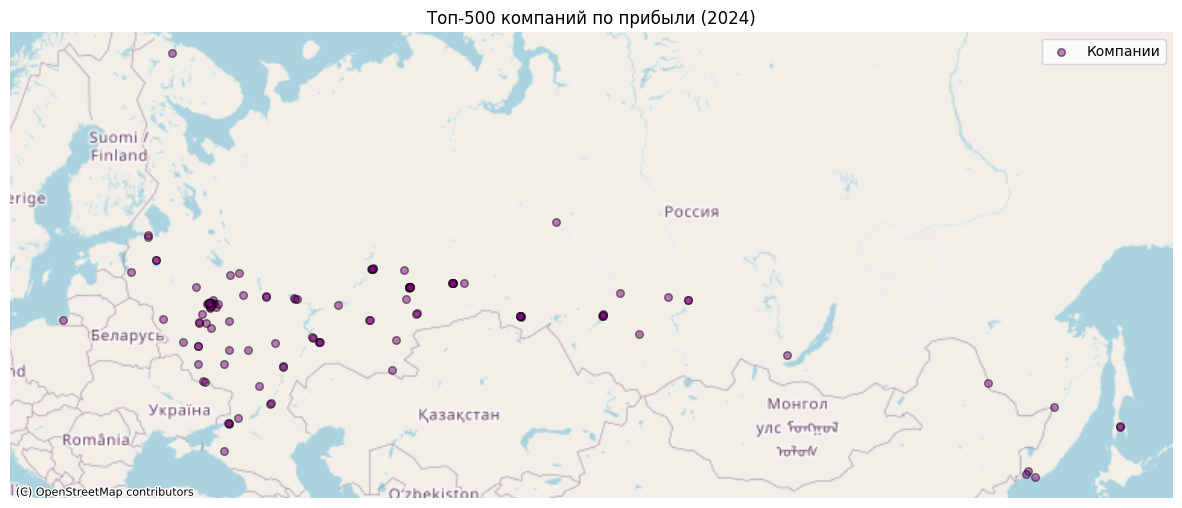

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

gdf.plot(
    ax=ax,
    markersize=30,
    color='purple',
    alpha=0.5,
    edgecolor='black',
    label='Компании'
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Топ-500 компаний по прибыли (2024)')
plt.axis('off')
plt.legend()
plt.show()

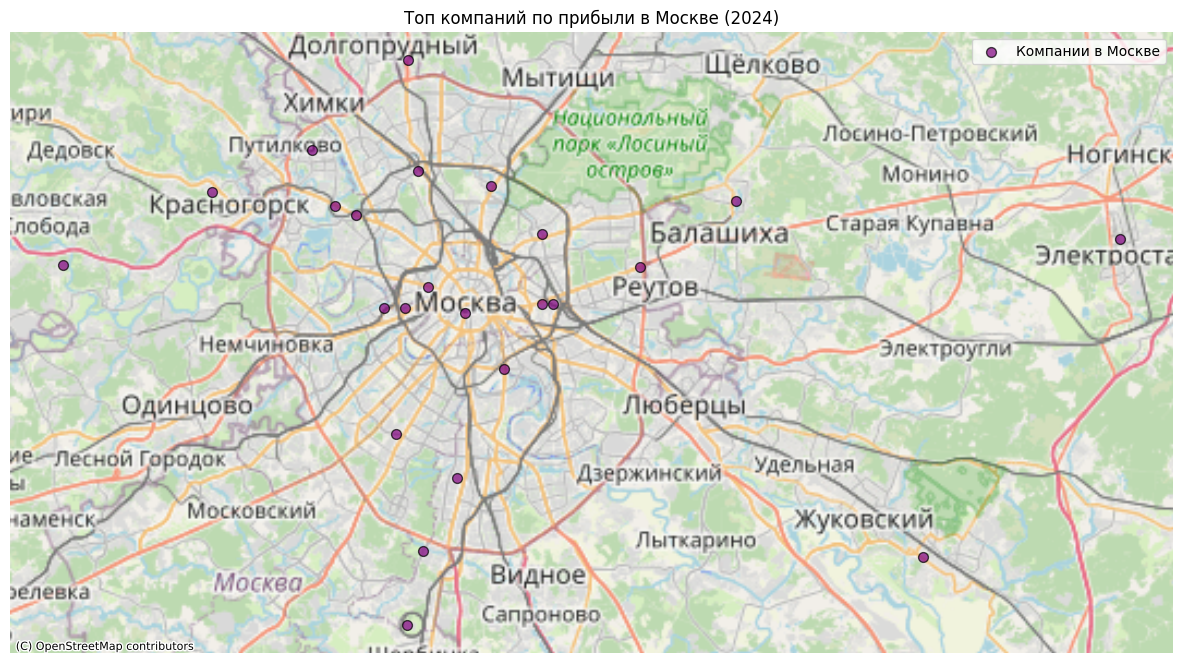

In [ ]:
moskow_bbox = {
    'min_lon': 36.5,
    'max_lon': 38.9,
    'min_lat': 55.5,
    'max_lat': 56.0
}

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

moskow_bbox = {
    'min_x': transformer.transform(moskow_bbox['min_lon'], moskow_bbox['min_lat'])[0],
    'max_x': transformer.transform(moskow_bbox['max_lon'], moskow_bbox['max_lat'])[0],
    'min_y': transformer.transform(moskow_bbox['min_lon'], moskow_bbox['min_lat'])[1],
    'max_y': transformer.transform(moskow_bbox['max_lon'], moskow_bbox['max_lat'])[1]
}

gdf_moscow = gdf.cx[
    moskow_bbox['min_x']:moskow_bbox['max_x'],
    moskow_bbox['min_y']:moskow_bbox['max_y']
]

fig, ax = plt.subplots(figsize=(15, 10))

gdf_moscow.plot(
    ax=ax,
    markersize=50,
    color='purple',
    alpha=0.7,
    edgecolor='black',
    label='Компании в Москве'
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Топ компаний по прибыли в Москве (2024)')
plt.axis('off')
plt.legend()
plt.show()

/tmp/ipython-input-27-2776670043.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby('Год').apply(


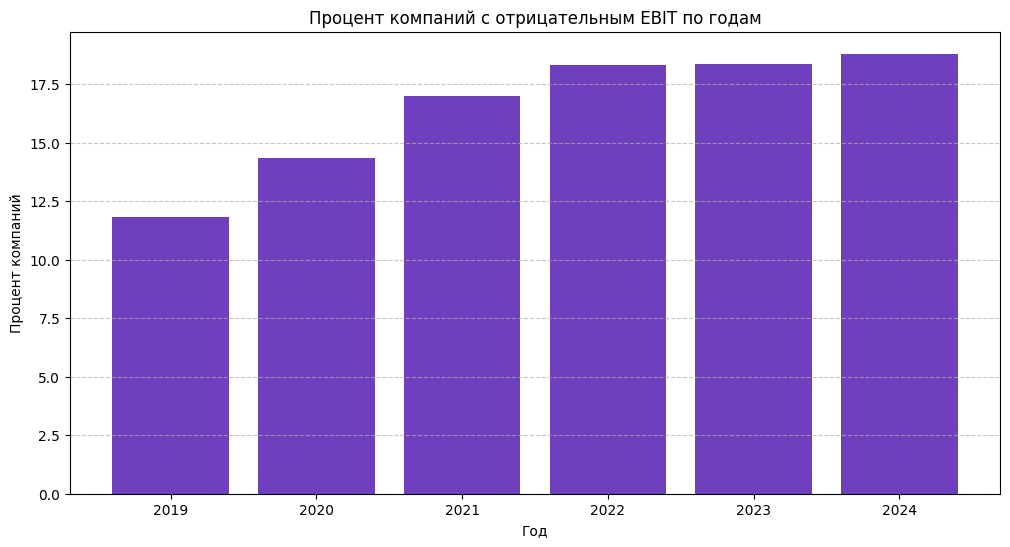

In [ ]:
df['EBIT'] = pd.to_numeric(df['EBIT'], errors='coerce')
df['Год'] = pd.to_numeric(df['Год'], errors='coerce')
result = df.groupby('Год').apply(
    lambda x: pd.Series({
        'total_companies': x['EBIT'].count(),  # Всего компаний с данными
        'negative_ebit': (x['EBIT'] < 0).sum()  # Количество с отрицательным EBIT
    })
).reset_index()

result['percent_negative'] = (result['negative_ebit'] / result['total_companies']) * 100
result = result[result['Год'] != 0]

plt.figure(figsize=(12, 6))
plt.bar(result['Год'], result['percent_negative'], color='#6e40bd')

plt.title('Процент компаний с отрицательным EBIT по годам')
plt.xlabel('Год')
plt.ylabel('Процент компаний')
plt.xticks(result['Год'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# <center>Анализ строительного рынка Российской Федерации</center>

## Введение:

Данный отчет подготовлен на основании данных, полученных с сайта ФНС (Федеральная налоговая служба), о финансовых показателях юридических лиц, относящихся к малым и средним предприятиям, а также данных, представленных на сайте [единой информационной системы жилищного строительства](https://наш.дом.рф) (ЕИСЖС).

## Анализ графиков

Первые пять графиков отражают распределение компаний по приросту прибыли за период в N лет. К сожалению, графики обладают низкой информативностью. Основное наблюдение: распределения выглядят схожими, что позволяет предположить отсутствие значимых изменений в динамике прироста прибыли за последние 5 лет.

Далее представлены две картограммы. На первой отмечены компании, входящие в топ-500 по прибыли за 2024 год (только те, для которых удалось определить координаты), на территории России. Вторая карта фокусируется на Москве. Ключевой вывод: наиболее успешные компании географически сконцентрированы в европейской части России.

Основная причина этой диспропорции видится в различии численности населения: по данным переписи 2021 года, в азиатской части страны проживает около 37 миллионов человек (примерно 1/4 населения России). Это обуславливает меньшую потребность в услугах строительных компаний и меньшее их количество на востоке страны.

Столбчатая диаграмма показывает долю компаний с отрицательным показателем EBIT по годам. Наблюдается тревожная тенденция: доля убыточных компаний последовательно растет, что свидетельствует о нарастании кризисных явлений в секторе.

## Анализ данных с ЕИСЖС

Подтверждение кризисной ситуации видно в динамике отношения показателя распроданности к показателю строительной готовности. Данный процент снизился со 105 в апреле 2021 года до 71 в июне 2025 года. При этом ситуацию сдерживают Центральный и Северо-Западный федеральные округа, где отношение находится на уровне 82% и 76% соответственно. В остальных округах показатель опустился ниже 70%. Наиболее критическая ситуация сложилась в Северо-Кавказском федеральном округе, где отношение составляет лишь 48%.

Снижение продаж жилья, вероятно, связано с высокой ключевой ставкой, которая привела к росту процентных ставок по ипотечным кредитам, сузив круг потенциальных покупателей. Дополнительным фактором является рост цен за квадратный метр за последние 5 лет. Подтверждением служит резкое сокращение ипотечного кредитования: количество выданных ипотечных кредитов в мае 2025 года снизилось на 57% по сравнению с маем 2024 года.

## Выводы
Проведенный анализ выявляет комплекс кризисных явлений в строительном секторе Российской Федерации:

ухудшение финансового состояния сектора: Растет доля убыточных малых и средних предприятий, что свидетельствует о системных проблемах рентабельности и финансовой устойчивости в отрасли.

кризис спроса на жилье: Данные ЕИСЖС подтверждают значительное снижение продаж на фоне роста строительной готовности. Ключевой индикатор – отношение распроданности к стройготовности – упал со 105% (апр. 2021) до 71% (июнь 2025), достигнув низких значений в большинстве федеральных округов (особенно в СКФО - 48%).

###Основные драйверы кризиса спроса

Высокая стоимость заимствований: резкий рост ключевой ставки привел к удорожанию ипотечных кредитов, существенно сузив круг платежеспособных покупателей (подтверждается падением выдачи ипотеки на 57% в мае 2025 по сравнению с маем 2024).

Рост цен на жилье: устойчивое повышение стоимости квадратного метра за последние 5 лет дополнительно ограничивает доступность жилья.

Таким образом, строительный рынок РФ сталкивается со значительными вызовами: структурным дисбалансом, ухудшением финансовых показателей компаний и глубоким кризисом спроса на жилье, спровоцированным дорогими кредитами и ростом цен. Для стабилизации ситуации необходимы адресные меры, направленные на стимулирование спроса и поддержку финансовой устойчивости участников рынка, особенно в регионах с наиболее сложной ситуацией.